In [32]:
import os
import sys
import cv2
import pygame

import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import fftpack


from src.utils.random_dot_motion import RandomDotMotion, draw, save_frames_to_video
from omegaconf import OmegaConf

In [53]:
def get_frames(pars={}, n_frames=300):
    # if kw exists, use it, otherwise use default values as follows
    pars.setdefault("seed", 1)
    pars.setdefault("coherence", 100)
    pars.setdefault("stimulus_size", (1280, 720))
    pars.setdefault("dot_radius", 17)
    pars.setdefault("dot_color", (255, 255, 255))
    pars.setdefault("dot_fill", 15)
    pars.setdefault("dot_vel", 350)
    pars.setdefault("dot_lifetime", 30)
    
    pygame.init()
    try:
        screen = pygame.display.set_mode(pars['stimulus_size'], pygame.FULLSCREEN | pygame.SCALED | pygame.DOUBLEBUF | pygame.HWSURFACE | pygame.NOFRAME)
    except pygame.error as e:
        print(f"Pygame error: {e}")
        pygame.quit()
        sys.exit()

    rdk = RandomDotMotion((1280, 720))
    rdk.new_stimulus(pars)

    frames = []
    for i in range(n_frames):
        rdk.move_dots(60)
        draw(screen, rdk.x, rdk.y, rdk.radius, rdk.color)
        window_pixel_matrix = pygame.surfarray.array2d(screen)
        frames.append(window_pixel_matrix)
    # convert list to numpy array
    frames = np.array(frames)
    # change coordinates from (time, y, x) to (time, x, y)
    frames = np.transpose(frames, (0, 2, 1))
        
    pygame.quit()
    return frames


def play_animation(frames):
    fig, ax = plt.subplots()
    ax.axis('off')  # Turn off axis for cleaner animation display
    img = ax.imshow(frames[0], cmap='gray', animated=True)

    def update(frame):
        img.set_array(frame)
        return img,

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)

    # Configure matplotlib to display the animation in Jupyter Notebook
    rc('animation', html='jshtml')
    
    # remove figure 
    plt.close()
    
    return ani


def plot_power_spectrum(data, pixels_per_degree=10, fps=60, cmap='viridis', title='Power Spectrum', TF_opt=8, SF_opt=0.5):
    
    """
    TF_opt: optimal temporal frequency in Hz for mice 4-8 Hz (taken from https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2020.00868/full)
    SF_opt: optimal spatial frequency in cycles/degree for mice 0.04 - 0.08 CPD (taken from Niell & Stryker, 2008)
    """
    
    
    time_steps, y_pixels, x_pixels = data.shape

    # Perform 3D FFT (time, y, x)
    fft_data = np.fft.fftn(data, axes=(0, 1, 2))
    # Compute the power spectrum
    power_spectrum = np.abs(fft_data)**2
    # Log transform the power spectrum
    log_power_spectrum = np.log(power_spectrum + 1e-10)  # Adding a small constant to avoid log(0)
    # Extract one frame of the original stimulus
    frame = data[data.shape[0]//2, :, :]
    # Compute the 2D spatial frequency distribution (SFx vs SFy)
    spatial_spectrum = np.mean(log_power_spectrum, axis=0)
    # Compute the 2D distribution of SFy vs TF and SFx vs TF
    sfy_vs_tf = np.mean(log_power_spectrum, axis=2)
    sfx_vs_tf = np.mean(log_power_spectrum, axis=1)
    # Convert pixel frequencies to cycles per degree
    spatial_freq_y = np.fft.fftfreq(y_pixels) * pixels_per_degree
    spatial_freq_x = np.fft.fftfreq(x_pixels) * pixels_per_degree
    # Convert temporal frequencies to Hz (frames per second)
    freq_time = np.fft.fftfreq(time_steps, d=1/fps)
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    # Plot one frame of the original stimulus
    axes[0, 0].imshow(frame, cmap='gray')
    axes[0, 0].set_title('One Frame of the Stimulus', fontsize=16)

    # Plot the spatial distribution of the log power spectrum (SFx vs SFy)
    im = axes[0, 1].imshow(np.fft.fftshift(spatial_spectrum), cmap=cmap, 
                        extent=[spatial_freq_x.min(), spatial_freq_x.max(), spatial_freq_y.min(), spatial_freq_y.max()])
    axes[0, 1].set_title('Spatial Log Power Spectrum (SFx vs SFy)', fontsize=16)
    axes[0, 1].set_ylabel('Spatial Frequency (cycles/degree)', fontsize=14)
    axes[0, 1].set_xlabel('Spatial Frequency (cycles/degree)', fontsize=14)
    axes[0, 1].set_ylim([spatial_freq_y.min(), spatial_freq_y.max()])
    axes[0, 1].set_xlim([spatial_freq_x.min(), spatial_freq_x.max()])
    # plot vertical and horizontal lines at +-0.5 cycles/degree
    axes[0, 1].axvline(x=SF_opt, color='r', linestyle='--')
    axes[0, 1].axvline(x=-SF_opt, color='r', linestyle='--')
    axes[0, 1].axhline(y=SF_opt, color='r', linestyle='--')
    axes[0, 1].axhline(y=-SF_opt, color='r', linestyle='--')
    
    # Plot SFy vs TF
    im = axes[1, 0].imshow(np.fft.fftshift(sfy_vs_tf), cmap=cmap, aspect='auto', 
                        extent=[spatial_freq_y.min(), spatial_freq_y.max(), freq_time.min(), freq_time.max()])
    axes[1, 0].set_title('SFy vs TF', fontsize=16)
    axes[1, 0].set_ylabel('Temporal Frequency (Hz)', fontsize=14)
    axes[1, 0].set_xlabel('Spatial Frequency (cycles/degree)', fontsize=14)
    axes[1, 0].set_ylim([freq_time.min(), freq_time.max()])
    axes[1, 0].set_xlim([spatial_freq_y.min(), spatial_freq_y.max()])
    # plot vertical lines at +-0.5 cycles/degree and horizontal lines at +-10 Hz
    axes[1, 0].axvline(x=SF_opt, color='r', linestyle='--')
    axes[1, 0].axvline(x=-SF_opt, color='r', linestyle='--')
    axes[1, 0].axhline(y=TF_opt, color='r', linestyle='--')
    axes[1, 0].axhline(y=-TF_opt, color='r', linestyle='--')
        
    # Plot SFx vs TF
    im = axes[1, 1].imshow(np.fft.fftshift(sfx_vs_tf), cmap=cmap, aspect='auto', 
                        extent=[spatial_freq_x.min(), spatial_freq_x.max(), freq_time.min(), freq_time.max()])
    axes[1, 1].set_title('SFx vs TF', fontsize=16)
    axes[1, 1].set_ylabel('Temporal Frequency (Hz)', fontsize=14)
    axes[1, 1].set_xlabel('Spatial Frequency (cycles/degree)', fontsize=14)
    axes[1, 1].set_ylim([freq_time.min(), freq_time.max()])
    axes[1, 1].set_xlim([spatial_freq_x.min(), spatial_freq_x.max()])
    # plot vertical lines at +-0.5 cycles/degree and horizontal lines at +-10 Hz
    axes[1, 1].axvline(x=SF_opt, color='r', linestyle='--')
    axes[1, 1].axvline(x=-SF_opt, color='r', linestyle='--')
    axes[1, 1].axhline(y=TF_opt, color='r', linestyle='--')
    axes[1, 1].axhline(y=-TF_opt, color='r', linestyle='--')
    
    plt.suptitle(title, fontsize=20)

    plt.tight_layout()
    plt.show()

    # return the power spectrum and figure
    return spatial_spectrum, sfx_vs_tf, sfy_vs_tf, fig

In [48]:
data_current = get_frames(pars = {'dot_radius': 17, 'dot_vel': 350}, n_frames=60)
data_slower_dots = get_frames(pars = {'dot_radius': 17, 'dot_vel': 200}, n_frames=60)
data_smaller_dots = get_frames(pars = {'dot_radius': 9, 'dot_vel': 350}, n_frames=60)
data_smaller_slower_dots = get_frames(pars = {'dot_radius': 9, 'dot_vel': 200}, n_frames=60)
data_high_lifetime_dots = get_frames(pars = {'dot_radius': 17, 'dot_vel': 350, 'dot_lifetime': 60}, n_frames=60)
data_high_lifetime_slower_dots = get_frames(pars = {'dot_radius': 17, 'dot_vel': 200, 'dot_lifetime': 60}, n_frames=60)

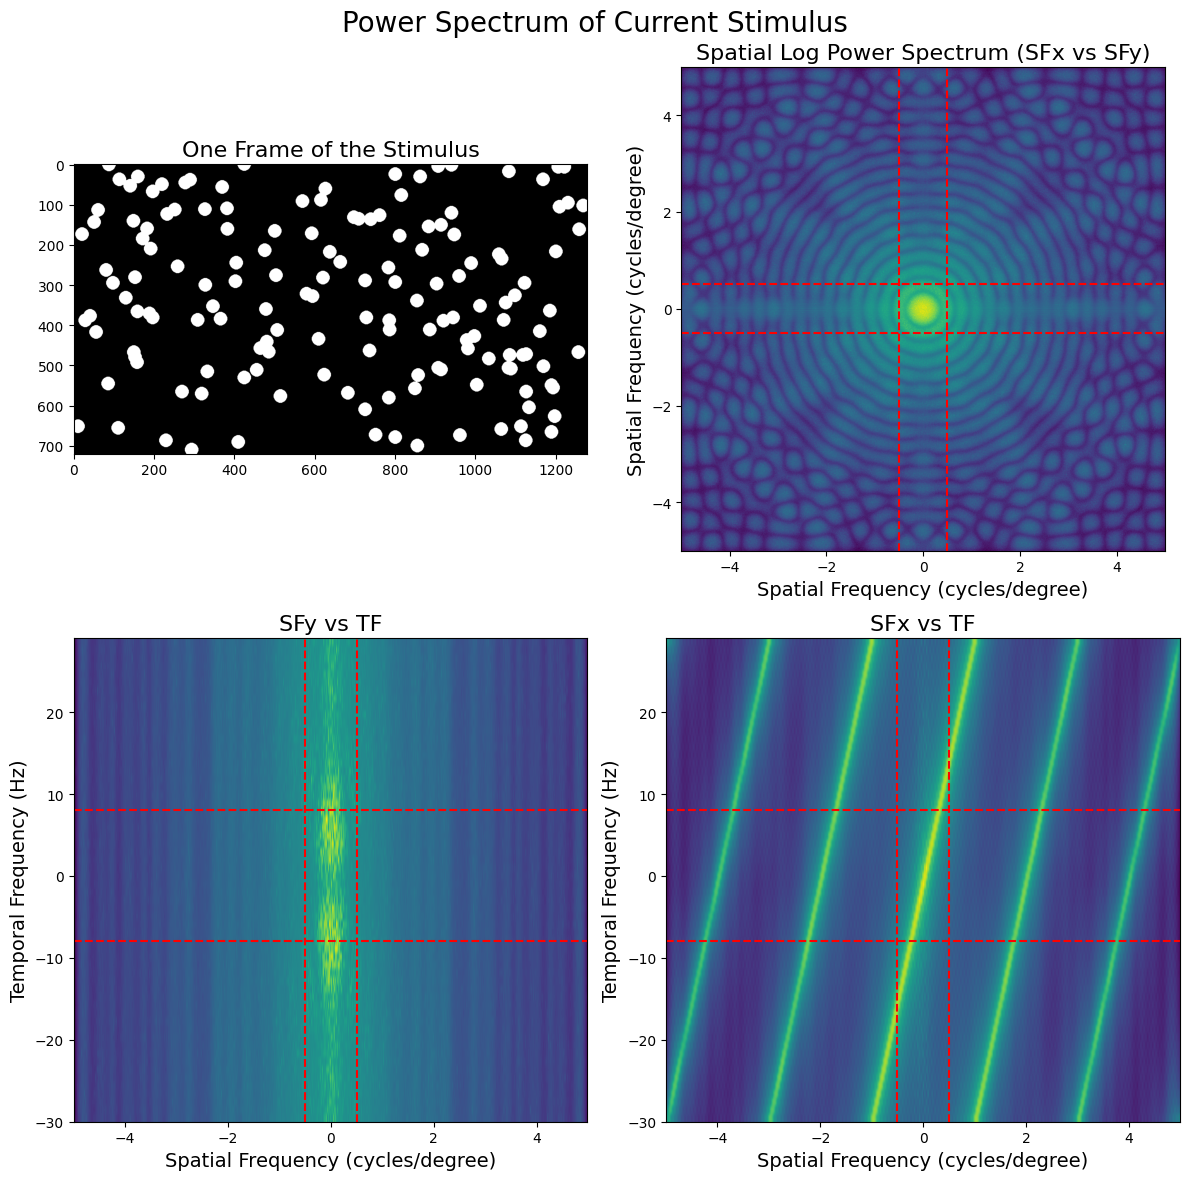

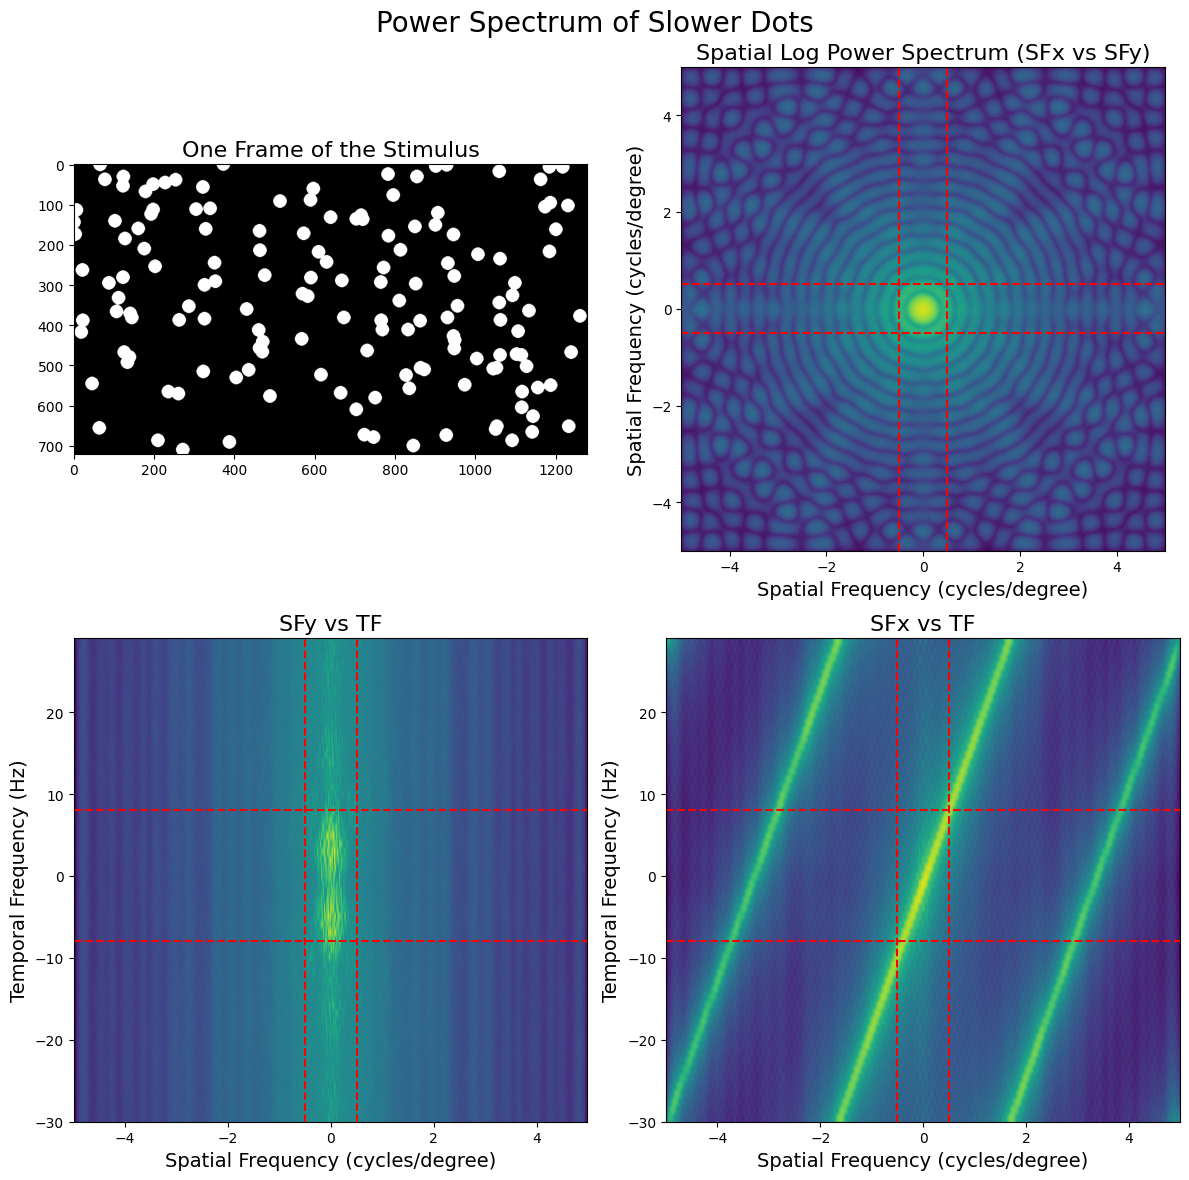

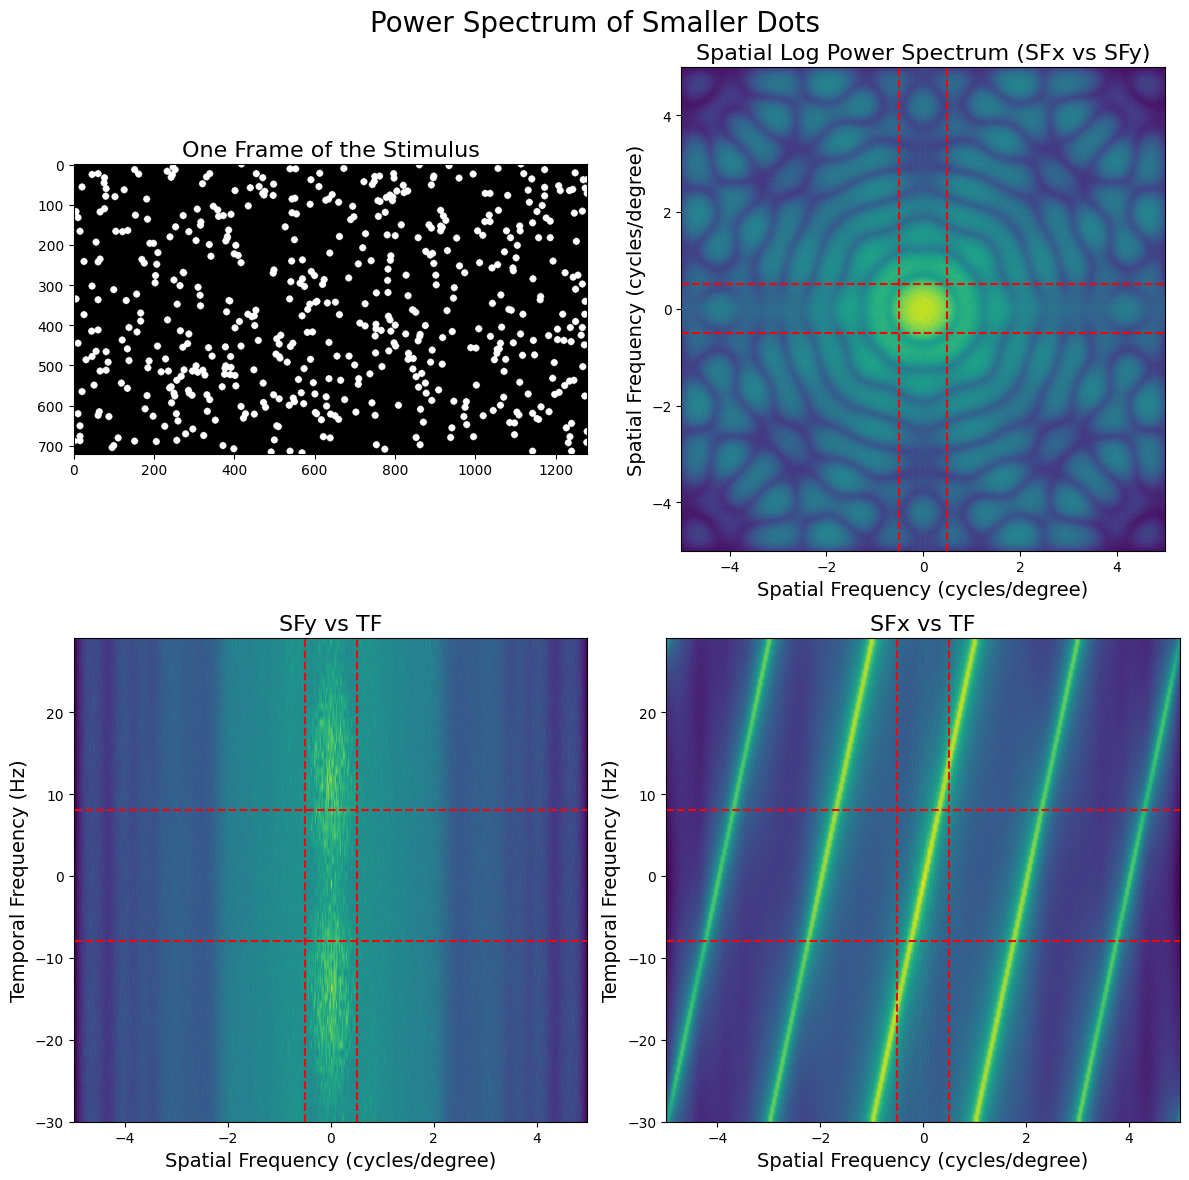

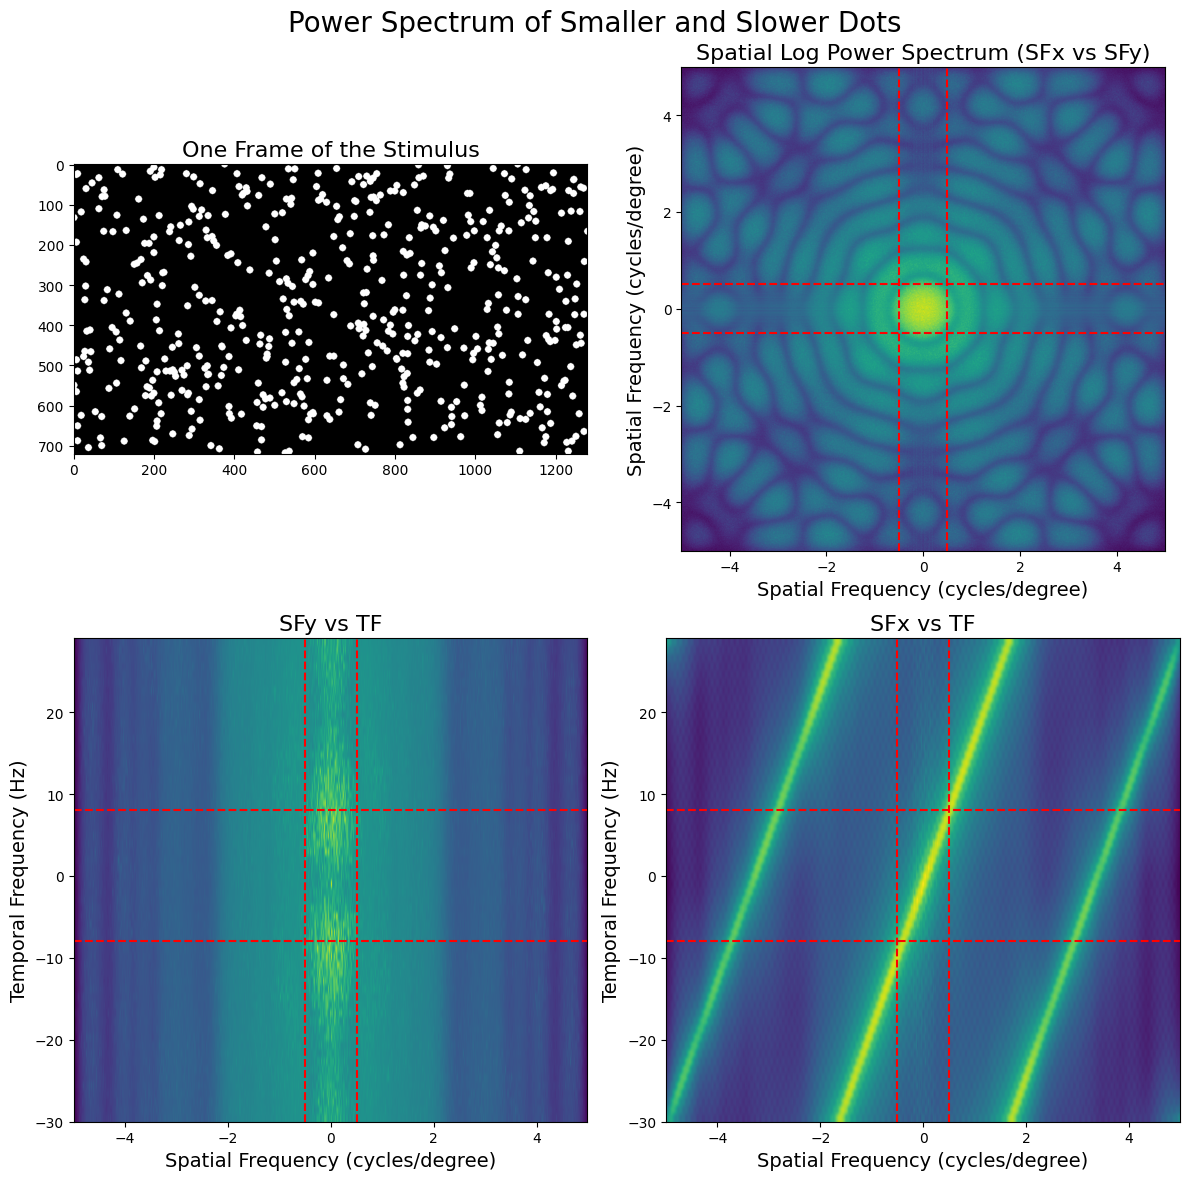

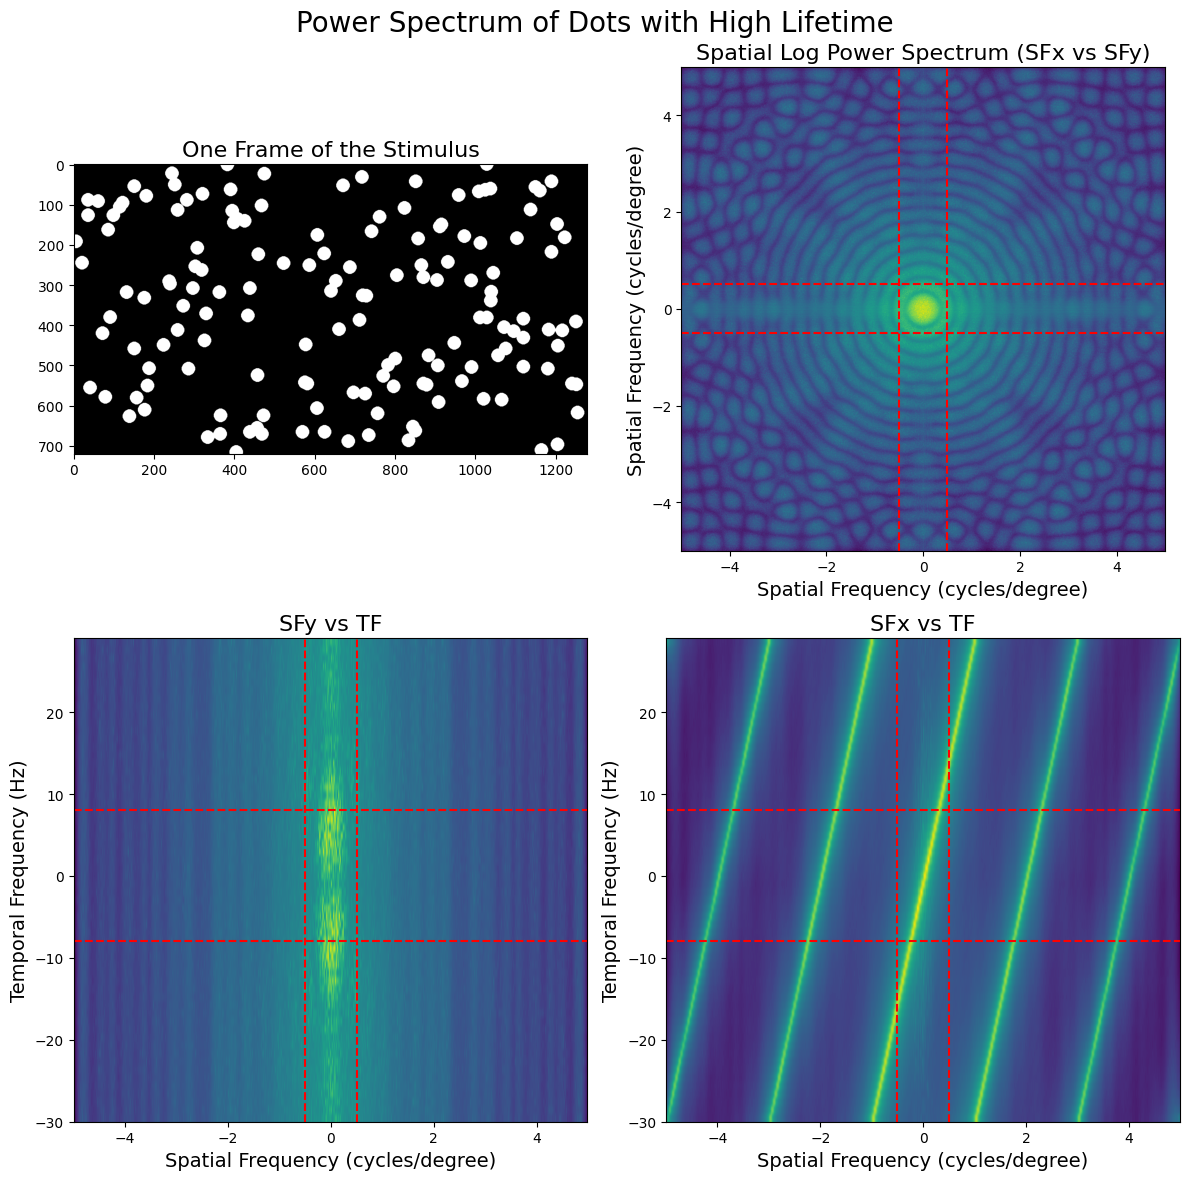

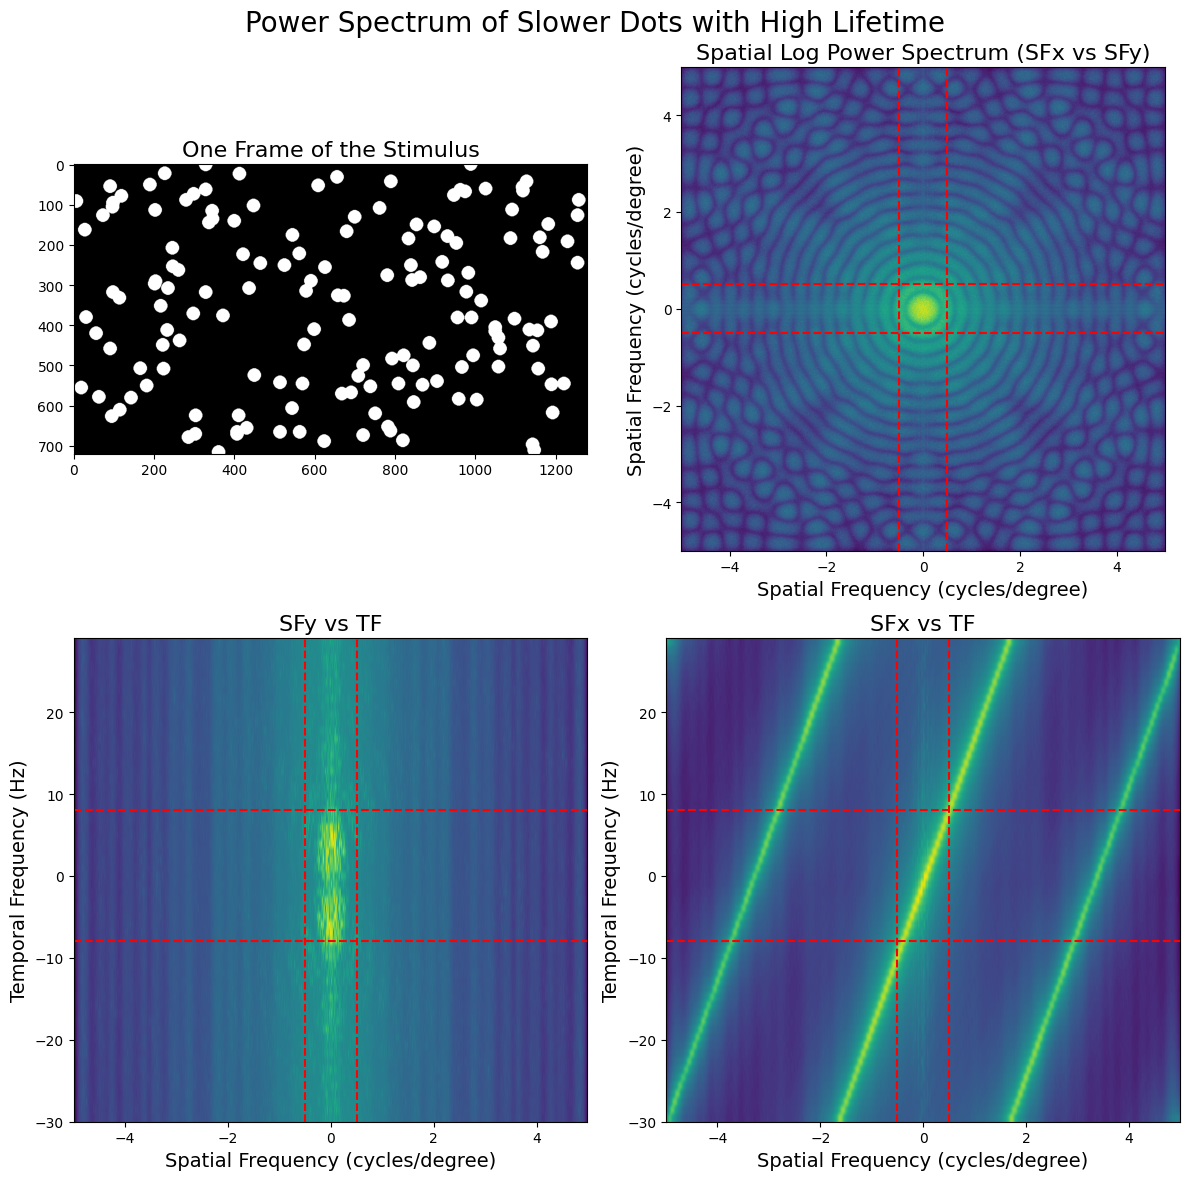

In [55]:
# Use the function
_, _, _, fig1 = plot_power_spectrum(data_current, title='Power Spectrum of Current Stimulus')
_, _, _, fig2 = plot_power_spectrum(data_slower_dots, title='Power Spectrum of Slower Dots')
_, _, _, fig3 = plot_power_spectrum(data_smaller_dots, title='Power Spectrum of Smaller Dots')
_, _, _, fig4 = plot_power_spectrum(data_smaller_slower_dots, title='Power Spectrum of Smaller and Slower Dots')
_, _, _, fig5 = plot_power_spectrum(data_high_lifetime_dots, title='Power Spectrum of Dots with High Lifetime')
_, _, _, fig6 = plot_power_spectrum(data_high_lifetime_slower_dots, title='Power Spectrum of Slower Dots with High Lifetime')

# Save the figures
fig1.savefig('../dissemination/power_spectrum_current.png')
fig2.savefig('../dissemination/power_spectrum_slower_dots.png')
fig3.savefig('../dissemination/power_spectrum_smaller_dots.png')
fig4.savefig('../dissemination/power_spectrum_smaller_slower_dots.png')
fig5.savefig('../dissemination/power_spectrum_high_lifetime_dots.png')
fig6.savefig('../dissemination/power_spectrum_high_lifetime_slower_dots.png')
